In [165]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [109]:
users = pd.read_csv(r'takehome_users.csv')
user_engagement = pd.read_csv(r'takehome_user_engagement.csv')

In [110]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [111]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [112]:
df = user_engagement.copy()
df2 = users.copy()


In [113]:
print(df2.shape, df.shape)

(12000, 10) (207917, 3)


In [114]:
df['time_stamp'] = df['time_stamp'].astype('datetime64[ns]')

In [115]:
df['time_stamp'] = df['time_stamp'].dt.floor('d').astype(np.int64)#this converts the date to the beginning of the day

In [116]:
df = df.sort_values(['user_id', 'time_stamp']).drop_duplicates() #drops duplicate dates since we are looking for 3 distinct dates

In [117]:
a = df.groupby('user_id')['time_stamp'].rolling(window=3) #groups by user, then takes 3 instances at a time

In [118]:
b = pd.to_timedelta((a.max()- a.min())).dt.days #takes the oldest and newest day of the 3 days and subtracts the count. count must be less than 3

In [119]:
c = b[b <= 7] #keeps the values where the difference is less than 7


In [120]:
print(c)

user_id        
2        9         6.0
         10        5.0
         11        7.0
10       24        7.0
         27        5.0
                  ... 
11988    207898    3.0
         207899    3.0
         207900    3.0
         207901    3.0
         207902    6.0
Name: time_stamp, Length: 167199, dtype: float64


In [121]:
e,f = map(list,zip(*c.index)) #E is the first index user_id

In [122]:
g = set(e)
g= list(g)
len(g)

1656

In [123]:
df['return'] =  df.index.isin(e)

In [124]:
df2.rename(columns = {'object_id':'user_id'}, inplace=True)

In [125]:
nlist = []

for x in df2['user_id']:
    if x in g:
        nlist.append(1)
    else:
        nlist.append(0)
df2['return'] = nlist
df2.rename(columns= {'return':'adopted_user'}, inplace=True)

In [126]:
dfo = df2[['creation_source']]
df5 = pd.concat([df2.drop(dfo, axis=1), pd.get_dummies(dfo)],axis=1) #dummy variables

In [127]:
df5['invited_by_user_id'].fillna(0, inplace=True)

In [128]:
df5['invited'] = df5['invited_by_user_id'] > 0

In [129]:
df5['invited'] = df5['invited']*1

In [130]:
df5.drop(df5.invited_by_user_id,inplace=True)

In [131]:
df5.fillna(0, inplace=True)

In [137]:
df5['last_session_creation_time'] = pd.to_datetime(df5['last_session_creation_time'])

In [147]:

X = df5.drop(columns=['last_session_creation_time','user_id','creation_time','name','email','org_id','invited_by_user_id','adopted_user']) #I could make a boolean for invited by adopted user
y = df5['adopted_user']

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [149]:
from sklearn.linear_model import LogisticRegression
Logreg = LogisticRegression(penalty = 'l2', C = .1,random_state = 40)
Logreg.fit(X_train,y_train)
y_pred_lr = Logreg.predict(X_test)

In [150]:
from sklearn.metrics import confusion_matrix
cnf_matrix= confusion_matrix(y_test,y_pred_lr)
print(cnf_matrix)
Accuracy_lr=Logreg.score(X_test,y_test)

print(Accuracy_lr)

[[2447    0]
 [ 384    0]]
0.8643588837866478


In [155]:
from sklearn.model_selection import cross_val_score

cv_scores_test= cross_val_score(Logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(Logreg,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_log_test= cv_scores_test.mean()
cv_scores_log_train= cv_scores_train.mean()
cv_scores_std_log= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_log_test))
print ('Mean cross validation train score: ' +str(cv_scores_log_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_log))

[0.57979062 0.51516479 0.52386264 0.57753698 0.56979055]
Mean cross validation test score: 0.5532291165043401
Mean cross validation train score: 0.5700479618230239
Standard deviation in cv scores: 0.02786377301184976


In [152]:
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score,  precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_lr, average='binary')
print('precision:', precision )
print('recall:',recall)
print('fscore:', fscore)
print('support:',support)

precision: 0.0
recall: 0.0
fscore: 0.0
support: None


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [158]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
logreg = LogisticRegression(penalty = 'l2',random_state = 40)
rs3 = GridSearchCV(estimator= logreg,param_grid= param_grid, scoring= 'accuracy', cv=5, n_jobs =-1 )

rs3 = rs3.fit(X_train, y_train)
print(rs3.best_estimator_)
print(rs3.best_score_)

LogisticRegression(C=0.001, random_state=40)
0.859176243892368


In [159]:
from sklearn.linear_model import LogisticRegression
Logreg = LogisticRegression(penalty = 'l2', C = .001,random_state = 40)
Logreg.fit(X_train,y_train)
y_pred_lr = Logreg.predict(X_test)

In [163]:
logreg = LogisticRegression(penalty = 'l2',random_state = 40, C= 1)
logreg.fit(X_train, y_train)
y_predictions_log = logreg.predict(X_test)
acc = accuracy_score(y_test, y_predictions_log)
cv = cross_val_score(logreg, X_test, y_test,scoring='roc_auc').mean()
print(acc)
print(cv)

0.8643588837866478
0.5528213809961123


                             Features  Importance scores  Absolute_val
4   creation_source_PERSONAL_PROJECTS          -0.608283      0.608283
6  creation_source_SIGNUP_GOOGLE_AUTH           0.352918      0.352918
2        creation_source_GUEST_INVITE           0.171192      0.171192
5              creation_source_SIGNUP           0.153145      0.153145
7                             invited           0.102316      0.102316
1          enabled_for_marketing_drip           0.096825      0.096825
3          creation_source_ORG_INVITE          -0.068876      0.068876
0            opted_in_to_mailing_list           0.047425      0.047425


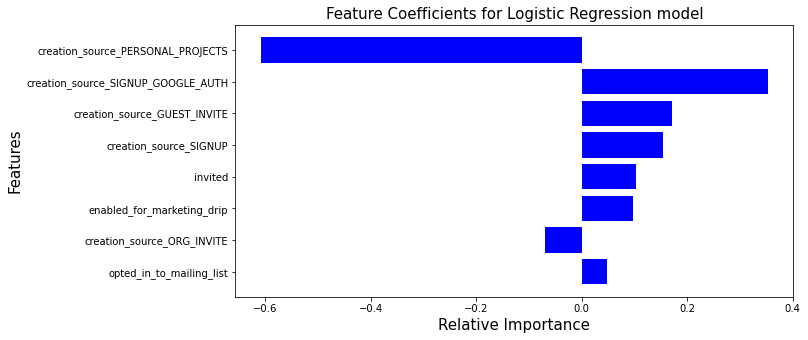

In [166]:
features = X
importances = logreg.coef_
absolute_importances = abs(logreg.coef_)
tab=pd.DataFrame(list(zip(X,importances[0], absolute_importances[0])),columns =['Features', 'Importance scores','Absolute_val']) 

sorted_features =tab.sort_values(by=['Absolute_val'], ascending=False)
print(sorted_features)
#Visual comparison:
plt.figure(figsize=(10,5))
index = list(range(len(sorted_features[:10])))
_=plt.barh(index,sorted_features['Importance scores'][:10], align='center',color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, sorted_features['Features'][:10])
plt.title('Feature Coefficients for Logistic Regression model',fontsize=15)
plt.gca().invert_yaxis()
plt.savefig("29.png")
plt.show()
#len(importances)